# Data Anlysis Final Test

## 데이터분석과 시각화, 머신러닝 알고리즘으로 시간당 자전거 대여량 예측<br><br>

**데이터 Preview**
- datetime - 시간, 연-월-일 시:분:초 로 표현<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; (가령 2011-01-01 00:00:00은 2011년 1월 1일 0시 0분 0초)
- season - 계절, 봄(1), 여름(2), 가을(3), 겨울(4) 순으로 표현
- holiday - 공휴일, 1이면 공휴일이며, 0이면 공휴일이 아님
- workingday - 근무일, 1이면 근무일이며, 0이면 근무일이 아님
- weather - 날씨, 1 ~ 4 사이의 값을 가지며, 구체적으로는 다음과 같다<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 1) 아주 깨끗한 날씨 또는 아주 약간의 구름이 끼어있다<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 2) 약간의 안개와 구름이 끼어있는 날씨<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 3) 약간의 눈, 비가 오거나 천둥이 친다<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 4) 아주 많은 비가 오거나 우박이 내린다<br>
- temp - 온도, 섭씨(Celsius)로 적혀있다
- atemp - 체감 온도, 마찬가지로 섭씨(Celsius)로 적혀있다
- humidity - 습도
- windspeed - 풍속
- casual - 비회원(non-registered)의 자전거 대여량
- registered - 회원(registered)의 자전거 대여량
- count - 총 자전거 대여량, 비회원(casual) + 회원(registered)과 동일

## 라이브러리

In [242]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from scipy.stats import shapiro, probplot
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## 데이터 불러오기

- 데이터 경로 설정

In [2]:
data_path = r"C:\Users\Jwp\Desktop\workspace\Etc\test\data"

- train, test 데이터를 불러온다

In [195]:
train = pd.read_csv(os.path.join(data_path, "train.csv"), encoding="euc-kr")
test = pd.read_csv(os.path.join(data_path, "test.csv"), encoding="euc-kr")

- 데이터 확인

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## 데이터 전처리

### 결측치 확인

- train의 결측치

In [10]:
pd.DataFrame({"null_count": train.isnull().sum()})

,null_count
datetime,0
season,0
holiday,0
workingday,0
weather,0
temp,0
atemp,0
humidity,0
windspeed,0
casual,0


- test의 결측치

In [11]:
pd.DataFrame({"null_count": test.isnull().sum()})

,null_count
datetime,0
season,0
holiday,0
workingday,0
weather,0
temp,0
atemp,0
humidity,0
windspeed,0


### 변수 확인

- datetime 변수 확인

In [80]:
len(train.datetime)

10886

In [63]:
train.datetime.head()

0    2011-01-01 00:00:00
1    2011-01-01 01:00:00
2    2011-01-01 02:00:00
3    2011-01-01 03:00:00
4    2011-01-01 04:00:00
Name: datetime, dtype: object

&nbsp; &nbsp; &nbsp; o **head()**를 통해 간략한 결과를 봤을 때 이미 1시간 단위로 처리되어 있는 것으로 보임

In [81]:
# 시간단위로 되어 있는지 확인하기 위해 시:분:초만 뽑음
time = []
for i in train.datetime:
    tmp = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
    tmp = "{:02}:{:02}:{:02}".format(tmp.hour, tmp.month, tmp.second)
    time.append(tmp)

In [126]:
# 유니크로 총 24개의 시간만 나오는지 확인
len(np.unique(time)), np.unique(time)

(288, array(['00:01:00', '00:02:00', '00:03:00', '00:04:00', '00:05:00',
        '00:06:00', '00:07:00', '00:08:00', '00:09:00', '00:10:00',
        '00:11:00', '00:12:00', '01:01:00', '01:02:00', '01:03:00',
        '01:04:00', '01:05:00', '01:06:00', '01:07:00', '01:08:00',
        '01:09:00', '01:10:00', '01:11:00', '01:12:00', '02:01:00',
        '02:02:00', '02:03:00', '02:04:00', '02:05:00', '02:06:00',
        '02:07:00', '02:08:00', '02:09:00', '02:10:00', '02:11:00',
        '02:12:00', '03:01:00', '03:02:00', '03:03:00', '03:04:00',
        '03:05:00', '03:06:00', '03:07:00', '03:08:00', '03:09:00',
        '03:10:00', '03:11:00', '03:12:00', '04:01:00', '04:02:00',
        '04:03:00', '04:04:00', '04:05:00', '04:06:00', '04:07:00',
        '04:08:00', '04:09:00', '04:10:00', '04:11:00', '04:12:00',
        '05:01:00', '05:02:00', '05:03:00', '05:04:00', '05:05:00',
        '05:06:00', '05:07:00', '05:08:00', '05:09:00', '05:10:00',
        '05:11:00', '05:12:00', '06:01:00',

&nbsp; &nbsp; &nbsp; o 시:분:초를 뽑아내고 **unique()**를 써서 확인해보니 시간단위가 아닌 것으로 확인<br>
&nbsp; &nbsp; &nbsp; o 시간당 자전거 대여량 분석을 위해 날짜별, 시간별 파생변수를 만들 필요가 있음

- 날짜별, 시간별 파생변수 생성

In [185]:
year = []
month = []
day = []
hour = []
for i in train.datetime:
    tmp = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
    year.append(tmp.year)
    month.append(tmp.month)
    day.append(tmp.day)
    hour.append(tmp.hour)

- year, month, day, hour 변수 확인

In [191]:
len(year), year[:5]

(10886, [2011, 2011, 2011, 2011, 2011])

In [192]:
len(month), month[:5]

(10886, [1, 1, 1, 1, 1])

In [193]:
len(day), day[:5]

(10886, [1, 1, 1, 1, 1])

In [194]:
len(hour), hour[:5]

(10886, [0, 1, 2, 3, 4])

- 기존 train 데이터에 변수 추가

In [196]:
train["year"] = year
train["month"] = month
train["day"] = day
train["hour"] = hour
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


## 데이터 분석

### 종속변수의 정규성 검정

- Shapiro Test

In [162]:
y = train["count"].to_list()
y[:5]

[16, 40, 32, 13, 1]

In [164]:
weight, p_value = shapiro(y)
print("[Weight: %.4f, P-value: %.4f]" % (weight, p_value))

[Weight: 0.8784, P-value: 0.0000]


&nbsp; &nbsp; &nbsp; o **P-value**가 매우 작아 정규성을 만족하지 않는 것으로 보이나 중심극한정리에 의해 분석을 이어가기로 한다

- 정규성 도표

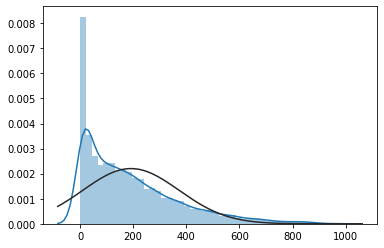

In [165]:
sns.distplot(y, fit=stats.norm)
plt.show()

&nbsp; &nbsp; &nbsp; o 왼쪽으로 값이 매우 치우쳐져 있다

### 독립변수와 종속변수의 상관관계

- 필요한 변수만으로 데이터프레임 재생성

In [197]:
variables = ["season", "holiday", "workingday", "weather", "temp", "atemp", 
             "humidity", "windspeed", "year", "month", "day", "hour", "count"]

In [198]:
ptrain = train[variables]
ptrain.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,count
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,0,16
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,1,40
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,2,32
3,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,3,13
4,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,4,1


- 상관분석

In [199]:
corr = ptrain.corr(method="pearson")

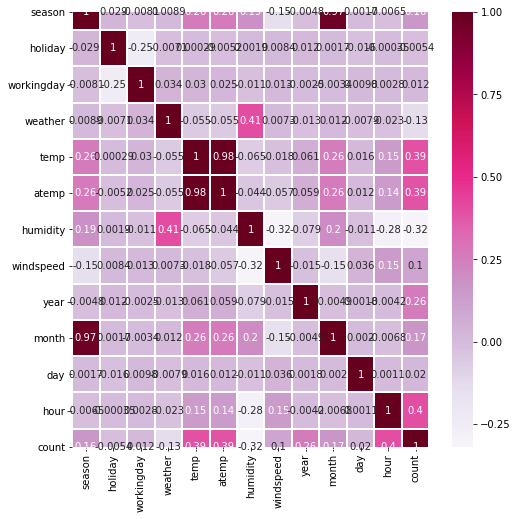

In [200]:
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, linewidths=1, cmap='PuRd')
plt.show()

- 상관관계 그래프

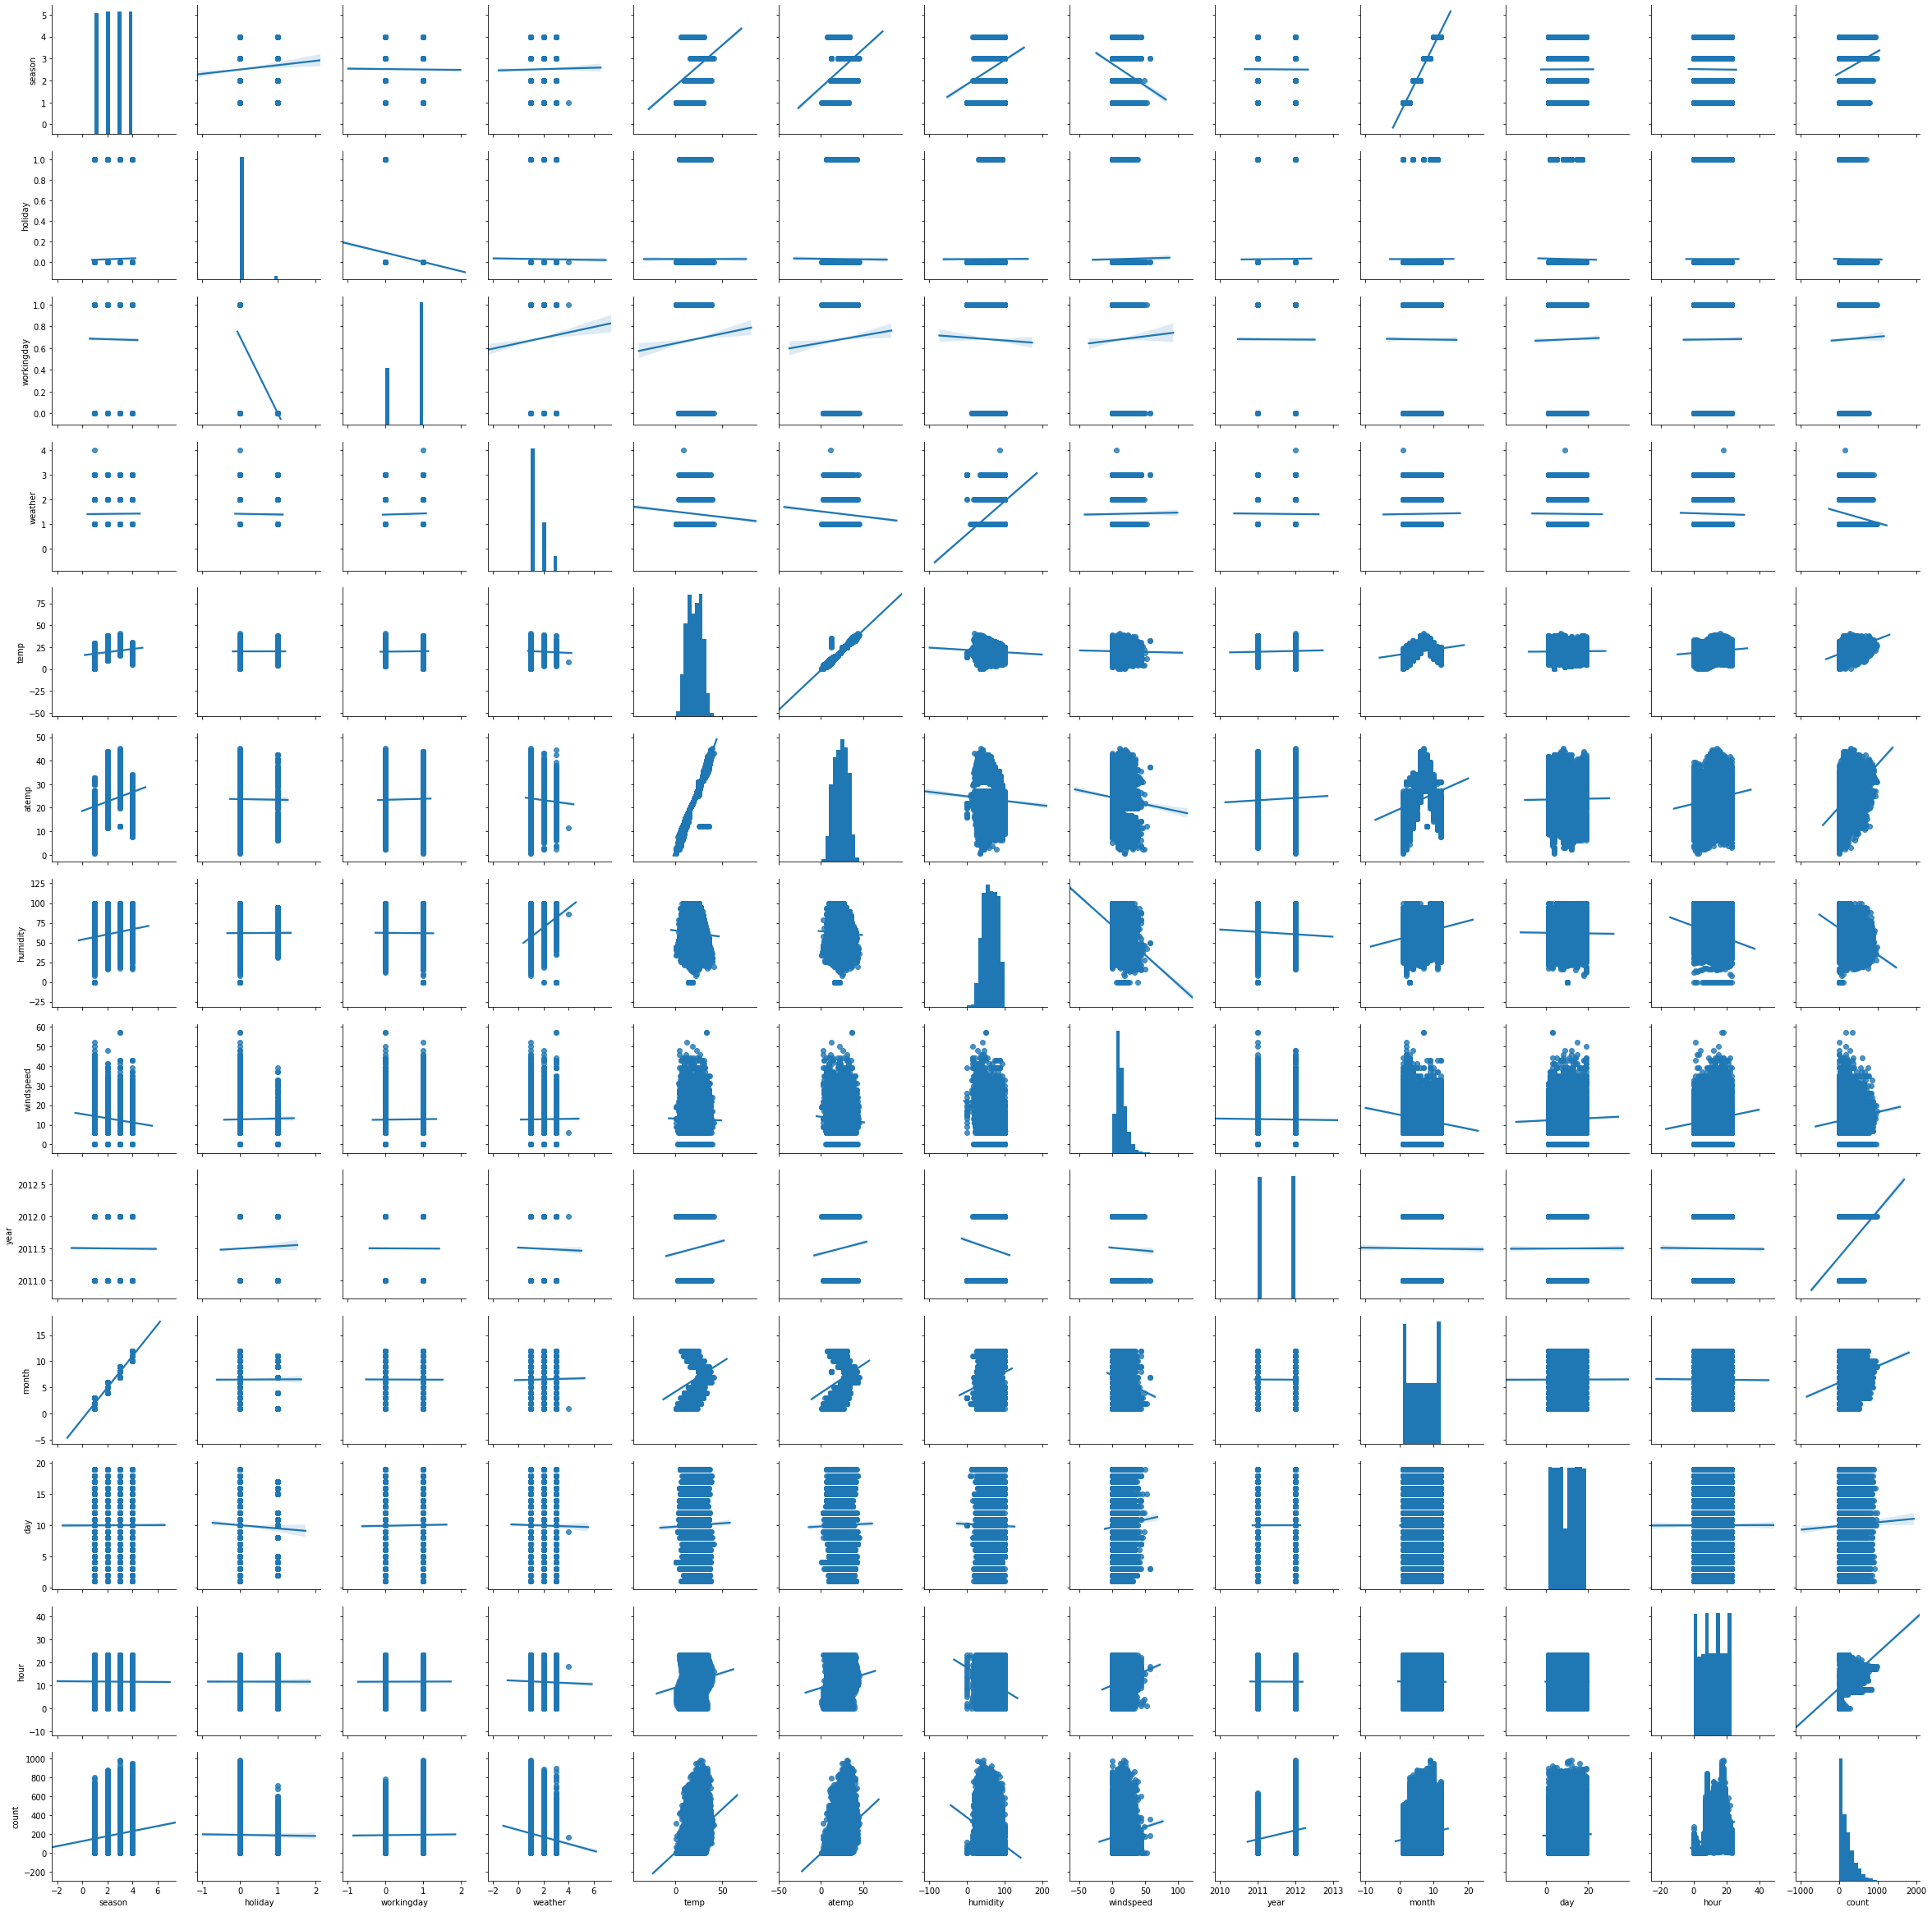

In [201]:
sns.pairplot(ptrain, kind="reg")

&nbsp; &nbsp; &nbsp; o **temp, atemp, year, hour** 네 변수가 상관관계가 높아 보인다

### 독립변수와 종속변수 설정

- 독립변수 설정

In [209]:
x = train.drop(["datetime", "casual", "registered", "count"], axis=1)
x.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,4


&nbsp; &nbsp; &nbsp; o **casual**과 **registered**는 **count**의 각 부분이고 **count**는 종속변수이므로 제거<br>
&nbsp; &nbsp; &nbsp; o **datetime**은 각 날짜별 시간단위 데이터이므로 index와 역할이 같아 제거

- 종속변수 설정

In [210]:
y = train["count"]
y.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

### 학습 데이터와 테스트 데이터 분할

In [211]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [212]:
x_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
613,1,0,1,1,9.02,9.090,32,39.0007,2011,2,8,17
4030,3,0,0,1,22.14,25.760,68,12.9980,2011,9,18,23
3582,3,0,1,1,26.24,28.790,83,0.0000,2011,8,19,4
10101,4,0,1,1,9.02,11.365,69,8.9981,2012,11,6,6
1430,2,0,1,3,13.12,14.395,81,30.0026,2011,4,5,11


In [214]:
y_train.head()

613      176
4030      54
3582       8
10101    149
1430      19
Name: count, dtype: int64

In [213]:
x_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
3133,3,0,1,1,33.62,40.150,59,0.0000,2011,7,19,11
5786,1,1,0,1,4.10,6.820,54,6.0032,2012,1,16,6
5224,4,0,0,1,9.84,11.365,48,12.9980,2011,12,11,18
8953,3,0,1,2,29.52,34.090,62,12.9980,2012,8,15,10
8054,2,0,1,1,25.42,31.060,53,16.9979,2012,6,15,23


In [215]:
y_test.head()

3133    127
5786     13
5224    163
8953    233
8054    222
Name: count, dtype: int64

### 선형회귀모델

- 모델 학습

In [216]:
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

- 모델 평가

In [238]:
predictions = lm.predict(x_test)

rmse = math.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("[RMSE: {}, R2: {}]".format(rmse, r2))

[RMSE: 141.2608997900608, R2: 0.3867713333068161]


&nbsp; &nbsp; &nbsp; o **R2**값을 보았을 때 학습이 잘 되지 않았다고 판단된다

### 서포트벡터머신

- 모델 학습

In [235]:
svm = SVR()
svm.fit(x_train, y_train)

C:\Users\Jwp\Anaconda3\envs\movie-inside\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

- 모델 평가

In [239]:
predictions = svm.predict(x_test)

rmse = math.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("[RMSE: {}, R2: {}]".format(rmse, r2))

[RMSE: 185.79079608323207, R2: -0.06078386039939554]


&nbsp; &nbsp; &nbsp; o **R2**값을 보았을 때 학습이 잘 되지 않았다고 판단된다

### 랜덤포레스트

- 모델 학습

In [240]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)

C:\Users\Jwp\Anaconda3\envs\movie-inside\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

- 모델 평가

In [241]:
predictions = rf.predict(x_test)

rmse = math.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("[RMSE: {}, R2: {}]".format(rmse, r2))

[RMSE: 45.72738804202965, R2: 0.9357413936346488]


&nbsp; &nbsp; &nbsp; o **RMSE**값이 가장 낮게 나왔고, **R2**값이 93.5로 매우 학습을 잘했다고 판단된다<br>
&nbsp; &nbsp; &nbsp; o 선형회귀모델, 서포트벡터머신, 랜덤포레스트 방법 중 랜덤포레스트의 결과지표가 <br>
&nbsp; &nbsp; &nbsp; &nbsp; 가장 좋은 것으로 나타나 최종모델을 랜덤포레스트로 선택한다

## test 데이터 전처리

In [244]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### train 데이터 전처리와 동일한 방법으로 수행

In [245]:
year = []
month = []
day = []
hour = []
for i in test.datetime:
    tmp = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
    year.append(tmp.year)
    month.append(tmp.month)
    day.append(tmp.day)
    hour.append(tmp.hour)

In [247]:
test["year"] = year
test["month"] = month
test["day"] = day
test["hour"] = hour
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4


In [249]:
variables = ["season", "holiday", "workingday", "weather", "temp", "atemp", 
             "humidity", "windspeed", "year", "month", "day", "hour"]
ptest = test[variables]
ptest.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4


### 랜덤포레스트 모델로 test 데이터 예측

In [250]:
predictions = rf.predict(ptest)
predictions

array([ 10. ,   5. ,   4.7, ..., 154.9, 124.8,  75.1])

### Submission 데이터프레임 생성

In [256]:
submission = pd.DataFrame([test.datetime, predictions], index=["datetime", "count"]).T
submission.head()

,datetime,count
0,2011-01-20 00:00:00,10
1,2011-01-20 01:00:00,5
2,2011-01-20 02:00:00,4.7
3,2011-01-20 03:00:00,3.4
4,2011-01-20 04:00:00,2.6


### CSV 파일로 최종 Submission 데이터 저장

In [257]:
submission.to_csv(os.path.join(data_path, "submission.csv"), index=None, encoding="euc-kr")